<a href="https://colab.research.google.com/github/dchriscothern/college-guard-tracking-sample/blob/main/college_guard_sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


===== POSSESSION SUMMARY =====

          pg_speed        pg_accel         cod_load dist_traveled
              mean   max      mean    max      mean           sum
advantage                                                        
0           1.0880  1.78  4.022727  10.50  6.568182      9.885346
1           2.1325  2.44  1.875000  12.75  9.875000      7.135774


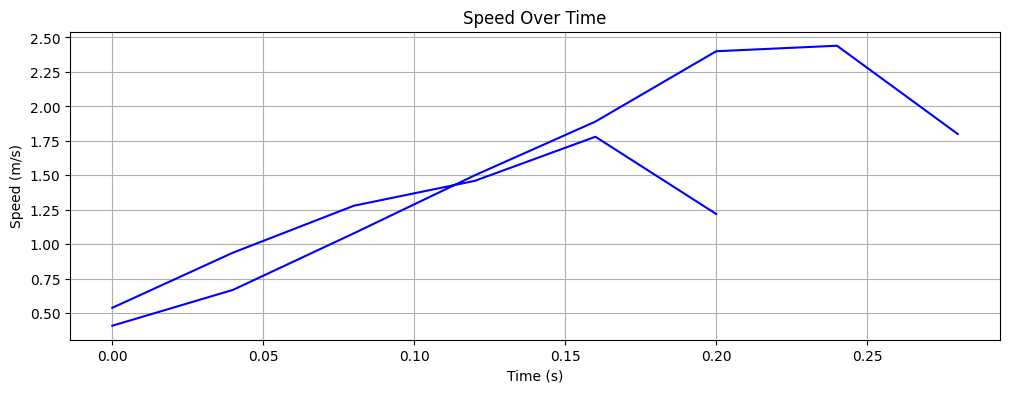

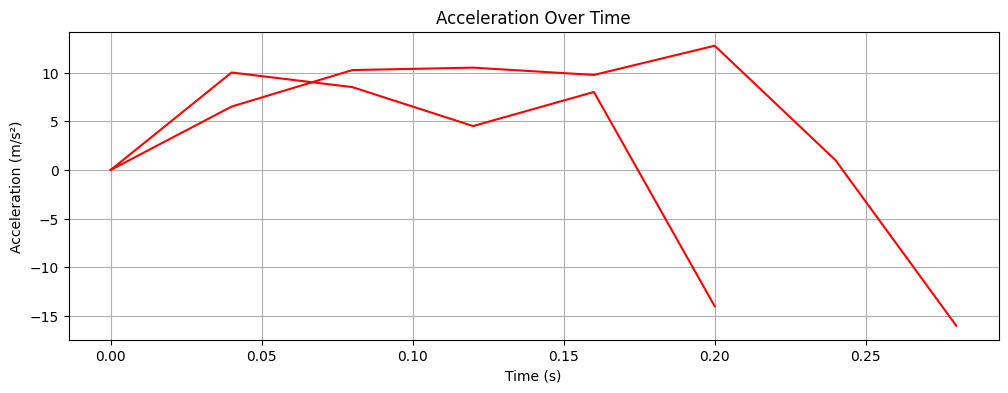

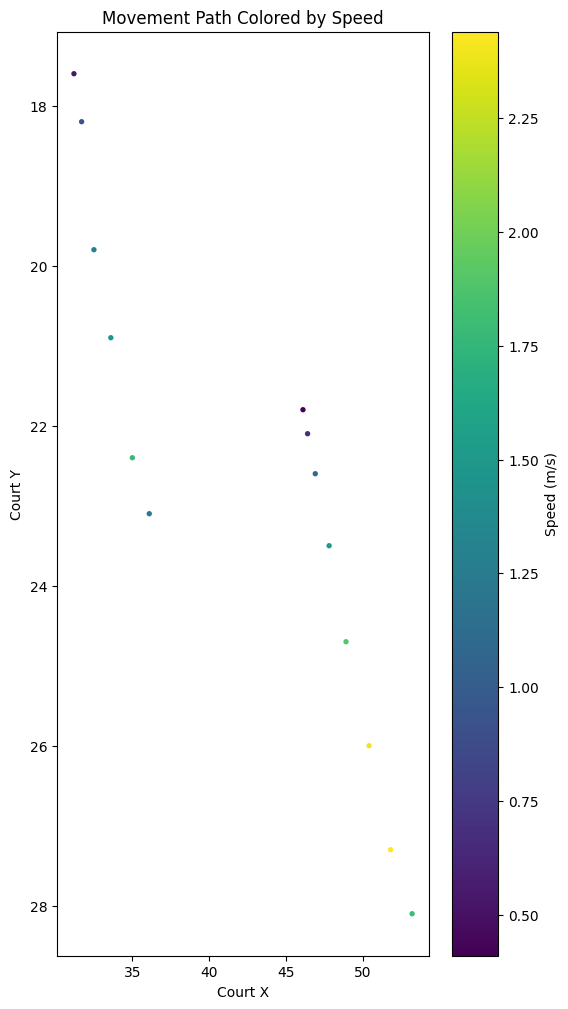

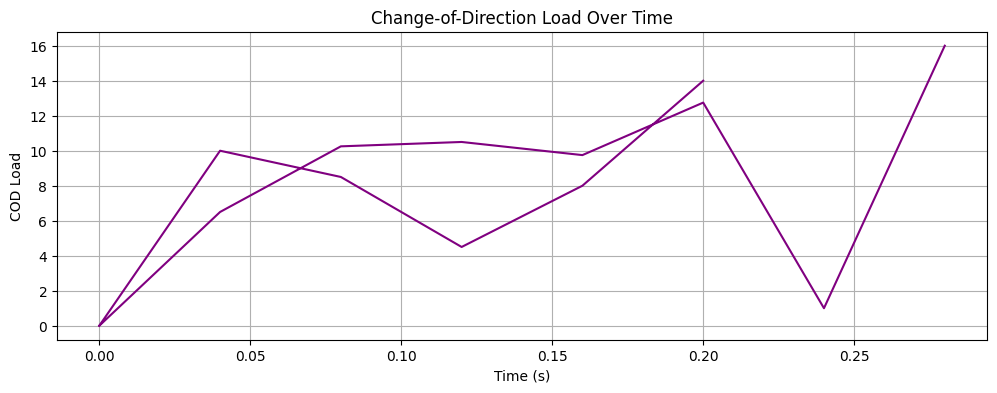

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================
# 1. Load data
# ============================================================
df = pd.read_csv("tracking_college_guard_sample.csv")

# ============================================================
# 2. Clean and ensure numeric columns
# ============================================================
numeric_cols = [
    "pg_x", "pg_y",
    "pg_vx", "pg_vy",
    "pg_speed",
    "advantage",
    "def_distance"
]

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

df["timestamp_s"] = df["timestamp_ms"] / 1000.0

# Advantage cannot be int if NaN exists → fix it
df["advantage"] = df["advantage"].fillna(0).astype(int)

# ============================================================
# 3. Derived Metrics
# ============================================================

# recompute speed if needed
df["computed_speed"] = np.sqrt(df["pg_vx"]**2 + df["pg_vy"]**2)

# Frame-to-frame acceleration
df["pg_accel"] = df["pg_speed"].diff() / df["timestamp_s"].diff()
df["pg_accel"] = df["pg_accel"].fillna(0)

# Change of direction load
df["cod_load"] = np.abs(df["pg_accel"])

# Distance traveled frame-to-frame
df["dist_traveled"] = np.sqrt(df["pg_x"].diff()**2 + df["pg_y"].diff()**2).fillna(0)

# High-speed flag
speed_threshold = df["pg_speed"].mean() + df["pg_speed"].std()
df["high_speed_flag"] = df["pg_speed"] > speed_threshold

# ============================================================
# 4. Possession-level summary
# ============================================================
summary = df.groupby("advantage").agg({
    "pg_speed": ["mean", "max"],
    "pg_accel": ["mean", "max"],
    "cod_load": "mean",
    "dist_traveled": "sum"
})

print("\n===== POSSESSION SUMMARY =====\n")
print(summary)

# ============================================================
# 5. VISUALIZATIONS — ORIGINAL
# ============================================================

# Speed over time
plt.figure(figsize=(12,4))
plt.plot(df["timestamp_s"], df["pg_speed"], color="blue")
plt.title("Speed Over Time")
plt.xlabel("Time (s)")
plt.ylabel("Speed (m/s)")
plt.grid(True)
plt.show()

# Acceleration over time
plt.figure(figsize=(12,4))
plt.plot(df["timestamp_s"], df["pg_accel"], color="red")
plt.title("Acceleration Over Time")
plt.xlabel("Time (s)")
plt.ylabel("Acceleration (m/s²)")
plt.grid(True)
plt.show()

# Movement path (tracking-style)
plt.figure(figsize=(6,12))
plt.scatter(df["pg_x"], df["pg_y"], s=8, c=df["pg_speed"], cmap="viridis")
plt.gca().invert_yaxis()
plt.colorbar(label="Speed (m/s)")
plt.title("Movement Path Colored by Speed")
plt.xlabel("Court X")
plt.ylabel("Court Y")
plt.show()

# COD Load timeline
plt.figure(figsize=(12,4))
plt.plot(df["timestamp_s"], df["cod_load"], color="purple")
plt.title("Change-of-Direction Load Over Time")
plt.xlabel("Time (s)")
plt.ylabel("COD Load")
plt.grid(True)
plt.show()

# ============================================================
# 6. NEW VISUALIZATIONS — HEATMAPS / SCOUTING ANALYTICS
# ============================================================

sns.set(style="white", font_scale=1.1)

# ----------------------------------------------------
# MOVEMENT DENSITY HEATMAP (KDE)
# ----------------------------------------------------
plt.figure(figsize=(8, 6))
sns.kdeplot(
    x=df["pg_x"],
    y=df["pg_y"],
    fill=True,
    cmap="viridis",
    shade=True,
    bw_adjust=0.6,
    thresh=0.05
)
plt.title("Movement Density Heatmap")
plt.xlabel("Court X")
plt.ylabel("Court Y")
plt.gca().invert_yaxis()
plt.show()

# ----------------------------------------------------
# SHOT LOCATION HEATMAP (if shots exist)
# ----------------------------------------------------
shot_data = df[df["action_tag"] == "shot"]

if len(shot_data) > 0:
    plt.figure(figsize=(8, 6))
    sns.kdeplot(
        x=shot_data["pg_x"],
        y=shot_data["pg_y"],
        fill=True,
        cmap="rocket",
        shade=True,
        bw_adjust=0.8,
        thresh=0.05
    )
    plt.scatter(
        shot_data["pg_x"],
        shot_data["pg_y"],
        c="white",
        edgecolor="black",
        s=40,
        label="Shot Attempts"
    )
    plt.title("Shot Density Heatmap with Event Overlay")
    plt.xlabel("Court X")
    plt.ylabel("Court Y")
    plt.gca().invert_yaxis()
    plt.legend()
    plt.show()
else:
    print("\nNo shot actions found for heatmap.\n")

# ----------------------------------------------------
# DEFENDER DISTANCE HEATMAP
# ----------------------------------------------------
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    df["pg_x"],
    df["pg_y"],
    c=df["def_distance"],
    cmap="coolwarm",
    s=25,
    alpha=0.8
)
plt.title("Defender Distance Heatmap")
plt.xlabel("Court X")
plt.ylabel("Court Y")
plt.gca().invert_yaxis()
cbar = plt.colorbar(scatter)
cbar.set_label("Defender Distance")
plt.show()
